In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import RandomOverSampler

## Importing the Dataset and Sampling 50 Lakh Rows randomly for training.

In [3]:
num_records = 40428967
sample_size = 5000000
skip_values = sorted(random.sample(range(1, num_records), num_records - sample_size))

train = pd.read_csv("../input/ctr-gz/train/train.csv",skiprows=skip_values)
train.head(2)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10000679056417042096,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157
1,10001966791793526909,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15701,320,50,1722,0,35,-1,79


## Importing the entire test Dataset.

In [4]:
test = pd.read_csv('../input/ctr-gz/test/test.csv')
test.head(2)

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000017e+19,14103100,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,...,1,0,8330,320,50,761,3,175,100075,23
1,1.000018e+19,14103100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,22676,320,50,2616,0,35,100083,51


In [5]:
import numpy as np
# Assuming 'train' is a pandas DataFrame
for col in ['C15', 'C16', 'C19', 'C21']:
    percentiles = train[col].quantile(0.98)
    if percentiles < 0.5 * train[col].max():
        train[col] = np.where(train[col] >= percentiles, percentiles, train[col])

## Defining numerical and categorical variables for a better classification model.


In [6]:
numerical = []
categorical = []

for col in (train.columns):
    if train[col].dtype == "object":
        categorical.append(col)
    else:
        numerical.append(col)
print("numerical columns = ",numerical)
print("\ncategorical columns = ",categorical)

numerical columns =  ['id', 'click', 'hour', 'C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']

categorical columns =  ['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model']


click
0    0.83016
1    0.16984
Name: proportion, dtype: float64




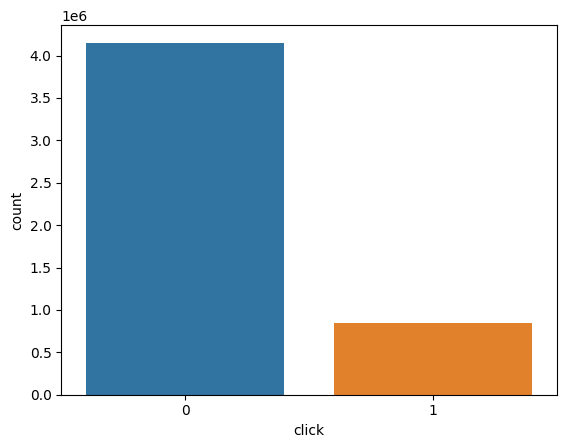

In [7]:
print(train.click.value_counts(normalize = True))
print("\n")
plt.figure()
sns.countplot(x='click', data=train)
plt.show()

## 83% values are 0 and 17% values are 1. data is highly imbalance.  Even if the model predicts 0 for every case we can easily achieve an accuracy of 83%. We can follow an approach where we balance the data and then train the model.

In [8]:
train.drop(['hour','C20'], axis=1, inplace=True)
train.columns

Index(['id', 'click', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C21'],
      dtype='object')

In [9]:
train.drop(['id'], axis = 1, inplace = True) 
train.rename(columns={'click': 'y'},
          inplace=True, errors='raise')

train.columns

Index(['y', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category',
       'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip',
       'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16',
       'C17', 'C18', 'C19', 'C21'],
      dtype='object')

In [10]:
sampled_data = train.sample(frac=0.1, random_state=42)
X = sampled_data.drop(['y'], axis=1)
y = sampled_data['y']

y
0    0.83016
1    0.16984
Name: proportion, dtype: float64




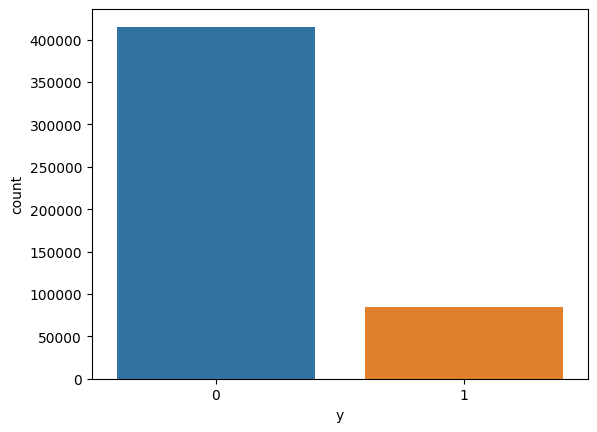

In [11]:
# After taking the sample of data, still the ratio of output remains same.

print(train.y.value_counts(normalize = True))
print("\n")
plt.figure()
sns.countplot(x=y)
plt.show()

In [12]:
import category_encoders as ce
target_encoder = ce.TargetEncoder()
X = target_encoder.fit_transform(X, y)
X.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21
3577888,1005,0,0.118946,0.122496,0.128413,0.308499,0.138623,0.248862,0.174136,0.147582,0.239521,1,0,23143,320.0,50.0,2665,0,35,221
4993932,1005,0,0.089336,0.095408,0.178904,0.198424,0.194530,0.198930,0.174136,0.147582,0.216474,1,0,20251,320.0,50.0,2323,0,687,48


## Since the data is imbalanced, i am balancing it using random oversampling

Original dataset shape  Counter({0: 415172, 1: 84828})
Resampled dataset shape Counter({0: 415172, 1: 415172})


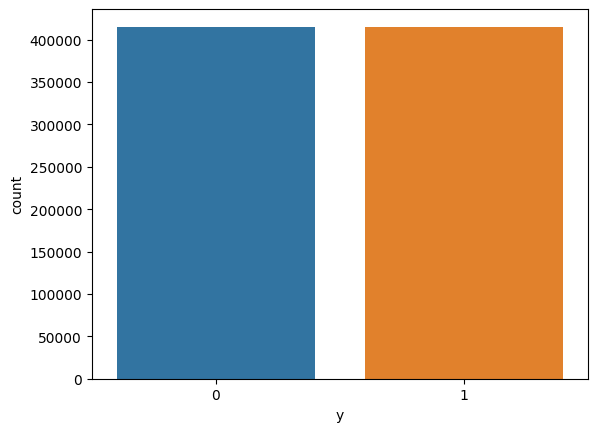

In [13]:
# x_new and y_new we will use for balanced data set for all modules
randomsample=  RandomOverSampler()
x_new, y_new = randomsample.fit_resample(X, y)

from collections import Counter
print('Original dataset shape  {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_new)))
sns.countplot(x=y_new)
plt.show()

In [14]:
x_new.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21
0,1005,0,0.118946,0.122496,0.128413,0.308499,0.138623,0.248862,0.174136,0.147582,0.239521,1,0,23143,320.0,50.0,2665,0,35,221
1,1005,0,0.089336,0.095408,0.178904,0.198424,0.194530,0.198930,0.174136,0.147582,0.216474,1,0,20251,320.0,50.0,2323,0,687,48


In [15]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, stratify=y_new, test_size= 0.3, random_state= 42)

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_train.head()

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21
99606,0.363636,0.0,0.260846,0.312019,0.421080,0.220048,0.313811,0.746860,0.216237,0.387823,0.384148,0.2,0.0,0.647625,1.0,0.130435,0.608696,0.000000,0.001107,0.307087
22973,0.363636,0.0,0.151494,0.186622,0.247722,0.087330,0.220591,0.189566,0.216237,0.264026,0.335209,0.2,0.6,0.998563,1.0,0.130435,0.996975,0.000000,0.005537,0.866142
59655,0.363636,0.0,0.260846,0.312019,0.421080,0.220048,0.313811,0.746860,0.216237,0.264026,0.596875,0.2,0.0,0.647837,1.0,0.130435,0.608696,0.000000,0.001107,0.307087
132133,0.363636,0.0,0.151494,0.186622,0.247722,0.022190,0.029347,0.284430,0.216237,0.264026,0.089542,0.2,0.6,0.879500,1.0,0.130435,0.874102,0.333333,0.070875,0.275591
803559,0.363636,0.0,0.151494,0.186622,0.247722,0.238400,0.347899,0.284430,0.216237,0.497687,0.449028,0.2,0.0,0.919596,1.0,0.130435,0.921739,0.333333,0.284607,0.196850


In [17]:
# Convert X_train and y_train to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)# Ensure y_train is a column vector

In [18]:
import torch.nn as nn

class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

In [19]:
import torch.optim as optim

# Initialize the model
input_dim = X_train_tensor.shape[1]
model = LogisticRegression(input_dim)

# Define the loss function
criterion = nn.BCELoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [20]:
num_epochs = 10000

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/10000], Loss: 0.6784
Epoch [200/10000], Loss: 0.6734
Epoch [300/10000], Loss: 0.6699
Epoch [400/10000], Loss: 0.6665
Epoch [500/10000], Loss: 0.6633
Epoch [600/10000], Loss: 0.6602
Epoch [700/10000], Loss: 0.6572
Epoch [800/10000], Loss: 0.6543
Epoch [900/10000], Loss: 0.6514
Epoch [1000/10000], Loss: 0.6487
Epoch [1100/10000], Loss: 0.6460
Epoch [1200/10000], Loss: 0.6434
Epoch [1300/10000], Loss: 0.6408
Epoch [1400/10000], Loss: 0.6384
Epoch [1500/10000], Loss: 0.6360
Epoch [1600/10000], Loss: 0.6336
Epoch [1700/10000], Loss: 0.6314
Epoch [1800/10000], Loss: 0.6291
Epoch [1900/10000], Loss: 0.6270
Epoch [2000/10000], Loss: 0.6248
Epoch [2100/10000], Loss: 0.6228
Epoch [2200/10000], Loss: 0.6207
Epoch [2300/10000], Loss: 0.6187
Epoch [2400/10000], Loss: 0.6168
Epoch [2500/10000], Loss: 0.6149
Epoch [2600/10000], Loss: 0.6130
Epoch [2700/10000], Loss: 0.6112
Epoch [2800/10000], Loss: 0.6094
Epoch [2900/10000], Loss: 0.6076
Epoch [3000/10000], Loss: 0.6059
Epoch [3100/10000],

In [21]:
# After training the model
with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    outputs = model(X_train_tensor)
    predicted = (outputs > 0.5).float()
    accuracy = (predicted == y_train_tensor).float().mean()
    print(f'Accuracy: {accuracy.item():.4f}')

Accuracy: 0.7999


In [22]:
# Convert X_train and y_train to PyTorch tensors
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)  # Ensure y_train is a column vector

## defining a function to make a precision recall chart

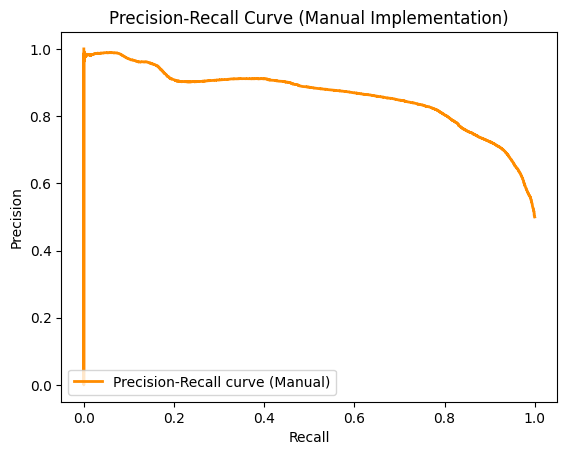

In [23]:
def precision_recall_manual(y_true, y_scores):
    sorted_indices = np.argsort(-y_scores)
    y_true_sorted = y_true[sorted_indices]
    y_scores_sorted = y_scores[sorted_indices]

    tp = 0 
    fp = 0  
    fn = sum(y_true) 
    
    precision_vals = []
    recall_vals = []
    prev_score = -1
    
    for i in range(len(y_scores_sorted)):
        if y_scores_sorted[i] != prev_score:  
            prev_score = y_scores_sorted[i]
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            precision_vals.append(precision)
            recall_vals.append(recall)
        if y_true_sorted[i] == 1:
            tp += 1
            fn -= 1
        else:
            fp += 1
    precision_vals = [1] + precision_vals
    recall_vals = [0] + recall_vals
    
    return np.array(precision_vals), np.array(recall_vals)

with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    outputs = model(X_train_tensor).numpy().flatten()  # Ensure outputs is 1D numpy array
    y_true = y_train_tensor.numpy().flatten()  # Ensure y_true is 1D numpy array

precision, recall = precision_recall_manual(y_true, outputs)

# plotting the graph using the above calculated values
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve (Manual)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Manual Implementation)')
plt.legend(loc="lower left")
plt.show()
